## Why Use `pykalman`

- Implements the **Kalman Filter**, a recursive algorithm for time series smoothing.
- Reduces noise and imputes missing data in sensor or process readings.
- Helps track true underlying trends despite noisy measurements.
- Improves data quality for better analysis and visualization.


In [1]:
pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 6.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [3]:
df = pd.read_csv('sensor_data.csv')

In [4]:
df.head()

,_id,flowmeter_1,flowmeter_2,pressure_3,flowmeter_4,flowmeter_5,flowmeter_6,flowmeter_7
0,2025-03-01 00:00:00,29.154518,2.381213,557.779602,1.789499,8.024493,3.090302,2.3148
1,2025-03-01 00:10:00,28.985508,2.406482,557.497742,1.815873,8.044760,3.109822,2.3328
2,2025-03-01 00:20:00,29.180040,2.427540,556.837219,1.840293,7.965942,3.128422,2.3512
3,2025-03-01 00:30:00,29.205606,2.445229,557.021484,1.864713,7.925407,3.144000,2.3676
4,2025-03-01 00:40:00,29.325514,2.465444,558.429871,1.890110,7.898383,3.161402,2.3856


In [5]:
df.describe()

,flowmeter_1,flowmeter_2,pressure_3,flowmeter_4,flowmeter_5,flowmeter_6,flowmeter_7
count,13236.000000,13247.000000,13248.000000,13247.000000,13239.000000,13248.000000,13247.000000
mean,21.352763,2.182232,507.935042,1.829418,5.264428,3.307234,2.657986
std,8.434696,0.391975,24.030270,0.141272,3.395918,0.262880,0.267827
min,0.000000,1.309793,0.000000,1.353846,-0.294212,2.590520,1.976400
25%,16.458197,1.836238,490.880005,1.725031,0.000000,3.097794,2.427999
50%,19.413706,2.117569,500.000000,1.837363,7.164248,3.341402,2.700614
75%,30.978935,2.405219,536.320007,1.943834,7.533567,3.509083,2.868400
max,40.551502,2.910184,559.679871,2.095238,15.163173,3.908099,3.202000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13248 entries, 0 to 13247
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          13248 non-null  object 
 1   flowmeter_1  13236 non-null  float64
 2   flowmeter_2  13247 non-null  float64
 3   pressure_3   13248 non-null  float64
 4   flowmeter_4  13247 non-null  float64
 5   flowmeter_5  13239 non-null  float64
 6   flowmeter_6  13248 non-null  float64
 7   flowmeter_7  13247 non-null  float64
dtypes: float64(7), object(1)
memory usage: 828.1+ KB


In [7]:
# Number of NaNs per column
null_counts = df.isna().sum()

# Combine both into a single DataFrame
summary = pd.DataFrame({
    'Null Values': null_counts
})

In [8]:
print(summary)

             Null Values
_id                    0
flowmeter_1           12
flowmeter_2            1
pressure_3             0
flowmeter_4            1
flowmeter_5            9
flowmeter_6            0
flowmeter_7            1


In [9]:
# Convert the '_id' column to datetime format
df['_id'] = pd.to_datetime(df['_id'])

# Set '_id' as the index
df.set_index('_id', inplace=True)

# Optional: sort the DataFrame by datetime index (recommended for time series)
df.sort_index(inplace=True)


### Checking the position of the null values in the dataset in `flowmeter 5`.

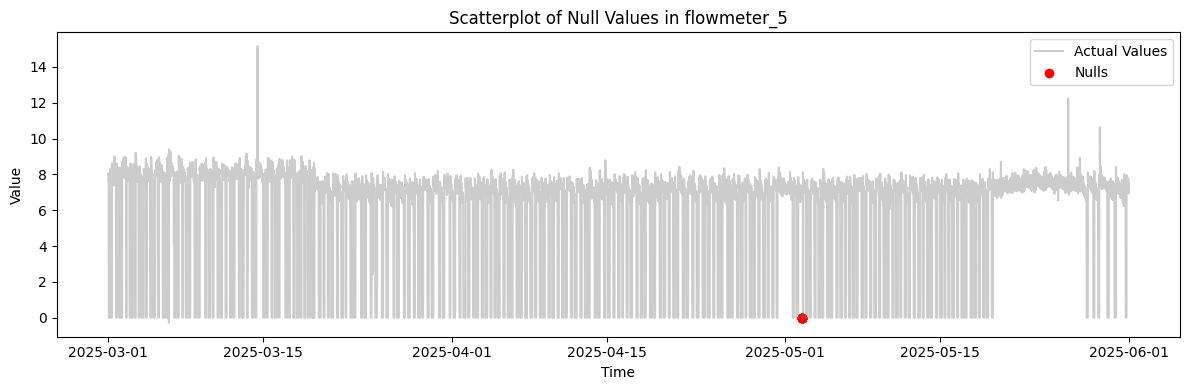

In [10]:
feature = 'flowmeter_5'

# Create a boolean mask for nulls
null_mask = df[feature].isna()

plt.figure(figsize=(12, 4))

# Plot full feature as a line
plt.plot(df.index, df[feature], label='Actual Values', color='gray', alpha=0.4)

# Scatter plot for NaN values
plt.scatter(df.index[null_mask], [0]*null_mask.sum(), color='red', label='Nulls')


plt.title(f"Scatterplot of Null Values in {feature}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


## Kalman Filter: How It Works & Its Importance in Time Series

- The **Kalman Filter** is an algorithm that estimates the true, underlying state of a system by combining noisy measurements with predictions from a mathematical model.
- It works recursively: at each step, it predicts the next state, receives a new observation, and updates its estimate to balance both.
- In time series analysis, the Kalman Filter is key for:
  - **Smoothing**: Filters out random noise while tracking actual trends.
  - **Imputation**: Fills in missing values using context from the entire data sequence.
  - **Real-time Updating**: Works efficiently as new data arrives, making it ideal for live sensor streams.
- Ultimately, the Kalman Filter provides more accurate, reliable data for analysis, modeling, and forecasting.


In [11]:
cols = ['flowmeter_2','pressure_3', 'flowmeter_4','flowmeter_5', 'flowmeter_7']

for col in cols:
    vals = df[col].values
    vals_masked = np.ma.masked_invalid(vals)

    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=np.nanmean(vals),
        initial_state_covariance=1,
        observation_covariance=1,
        transition_covariance=0.01
    )
    kf = kf.em(vals_masked, n_iter=5)
    smoothed_state_means, _ = kf.smooth(vals_masked)
    kalman_1d = smoothed_state_means.flatten()

    # Copy original values
    filled = vals.copy()
    nan_mask = np.isnan(vals)
    filled[nan_mask] = kalman_1d[nan_mask]

    # Assign imputed values to a new column
    df[f'{col}_imputed'] = filled


In [12]:
# Ensure your DataFrame has 'flowmeter_1' and 'pressure'
obs = df[['flowmeter_1', 'pressure_3']].values
# Mask missing values (pykalman handles these naturally)
obs_masked = np.ma.masked_invalid(obs)


### Using Multivariate Kalman filter as `flowmeter 1` and `pressure 3` are highly correlated.

In [13]:

kf = KalmanFilter(
    n_dim_obs=2,
    n_dim_state=2,
    initial_state_mean=np.nanmean(obs, axis=0),
    initial_state_covariance=np.eye(2),
    transition_matrices=np.eye(2),           # Adjust if you have a process model
    observation_matrices=np.eye(2),
    observation_covariance=np.eye(2),        # Estimate or set based on data
    transition_covariance=0.01 * np.eye(2)   # Small process noise
)


In [14]:
# Fit parameters using Expectation-Maximization (EM), helpful with missing data
kf = kf.em(obs_masked, n_iter=10)

# Apply smoothing to estimate all positions, including missing values
state_means, _ = kf.smooth(obs_masked)


In [15]:
imputed = df['flowmeter_1'].copy()
missing_mask = df['flowmeter_1'].isna()
imputed[missing_mask] = state_means[missing_mask, 0]  # 0th column corresponds to flowmeter_1

df['flowmeter_1_imputed'] = imputed


### As these are two features with more missing values so we make two new features where we encode the missing and non missing values.

In [16]:
# Create mask flags: True if original was NaN (i.e., imputed)
df['flowmeter_1_missing_flag'] = df['flowmeter_1'].isna()
df['flowmeter_5_missing_flag'] = df['flowmeter_5'].isna()

In [17]:
df['flowmeter_1_missing_flag'] = df['flowmeter_1_missing_flag'].astype(int)
df['flowmeter_5_missing_flag'] = df['flowmeter_5_missing_flag'].astype(int)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   flowmeter_1               13236 non-null  float64
 1   flowmeter_2               13247 non-null  float64
 2   pressure_3                13248 non-null  float64
 3   flowmeter_4               13247 non-null  float64
 4   flowmeter_5               13239 non-null  float64
 5   flowmeter_6               13248 non-null  float64
 6   flowmeter_7               13247 non-null  float64
 7   flowmeter_2_imputed       13248 non-null  float64
 8   pressure_3_imputed        13248 non-null  float64
 9   flowmeter_4_imputed       13248 non-null  float64
 10  flowmeter_5_imputed       13248 non-null  float64
 11  flowmeter_7_imputed       13248 non-null  float64
 12  flowmeter_1_imputed       13248 non-null  float64
 13  flowmeter_1_missing_flag  

In [19]:
# This will select only columns with no nulls (completely filled columns)
df_updated = df.loc[:, df.notnull().all()]

# The DateTimeIndex (your time index) remains unchanged,
# and you'll keep only the columns where ALL values are non-null

print(df_updated.shape)


(13248, 10)


In [20]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pressure_3                13248 non-null  float64
 1   flowmeter_6               13248 non-null  float64
 2   flowmeter_2_imputed       13248 non-null  float64
 3   pressure_3_imputed        13248 non-null  float64
 4   flowmeter_4_imputed       13248 non-null  float64
 5   flowmeter_5_imputed       13248 non-null  float64
 6   flowmeter_7_imputed       13248 non-null  float64
 7   flowmeter_1_imputed       13248 non-null  float64
 8   flowmeter_1_missing_flag  13248 non-null  int64  
 9   flowmeter_5_missing_flag  13248 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 1.1 MB


In [21]:
df_updated = df_updated.drop(columns = 'pressure_3_imputed')

In [22]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pressure_3                13248 non-null  float64
 1   flowmeter_6               13248 non-null  float64
 2   flowmeter_2_imputed       13248 non-null  float64
 3   flowmeter_4_imputed       13248 non-null  float64
 4   flowmeter_5_imputed       13248 non-null  float64
 5   flowmeter_7_imputed       13248 non-null  float64
 6   flowmeter_1_imputed       13248 non-null  float64
 7   flowmeter_1_missing_flag  13248 non-null  int64  
 8   flowmeter_5_missing_flag  13248 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.0 MB


In [23]:
df_updated.describe()

,pressure_3,flowmeter_6,flowmeter_2_imputed,flowmeter_4_imputed,flowmeter_5_imputed,flowmeter_7_imputed,flowmeter_1_imputed,flowmeter_1_missing_flag,flowmeter_5_missing_flag
count,13248.000000,13248.000000,13248.000000,13248.000000,13248.000000,13248.000000,13248.000000,13248.000000,13248.000000
mean,507.935042,3.307234,2.182218,1.829430,5.264257,2.658014,21.353103,0.000906,0.000679
std,24.030270,0.262880,0.391963,0.141273,3.394784,0.267836,8.431010,0.030084,0.026056
min,0.000000,2.590520,1.309793,1.353846,-0.294212,1.976400,0.000000,0.000000,0.000000
25%,490.880005,3.097794,1.836238,1.725031,0.000000,2.428000,16.460905,0.000000,0.000000
50%,500.000000,3.341402,2.117569,1.837363,7.163122,2.700614,19.417477,0.000000,0.000000
75%,536.320007,3.509083,2.405008,1.943834,7.533567,2.868400,30.969341,0.000000,0.000000
max,559.679871,3.908099,2.910184,2.095238,15.163173,3.202000,40.551502,1.000000,1.000000


In [24]:
# Step 2: Compute correlation matrix
corr_matrix = df_updated.corr()

## Why Use Cluster Maps for Time Series Data

- **Cluster maps** visually group similar time series or features using hierarchical clustering, displayed as a heatmap with a dendrogram.
- They help quickly reveal correlated patterns, groups, or anomalies in high-dimensional time series data.
- **Advantages:**
  - Uncover hidden relationships between variables or time intervals.
  - Highlight underlying structure or redundancy, guiding feature selection.
  - Flexible: show both row and column clusters simultaneously for complex datasets.
- **Interpretability:**
  - The color gradients in the heatmap represent the similarity or distance between values—brighter or similar colors indicate related time series.
  - Dendrogram branches make it easy to interpret which signals or periods are closely linked.
- **In summary:** Cluster maps turn large, complex time series datasets into an interpretable visual summary, making exploratory analysis and insights more accessible.


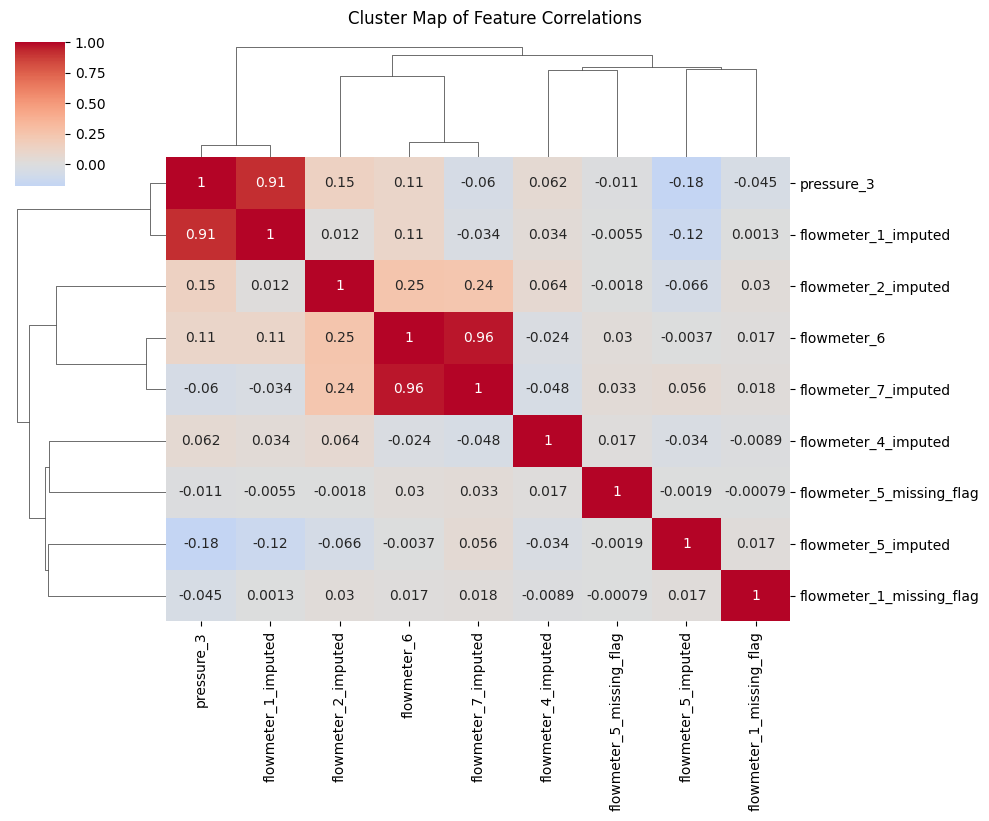

In [25]:
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', figsize=(10, 8), center=0)
plt.suptitle("Cluster Map of Feature Correlations", y=1.02)
plt.show()


## Why Use Robust Scaler for Anomaly Detection

- The **Robust Scaler** normalizes data using statistics that are robust to outliers (median and interquartile range), rather than mean and standard deviation.
- In anomaly detection, data often contains extreme values or outliers by definition; using Robust Scaler prevents these from skewing the scaling.
- This leads to more stable and meaningful feature scaling that preserves the integrity of both normal and anomalous points.
- Consequently, models can better distinguish true anomalies from noise, improving detection accuracy and reducing false positives.


In [26]:
# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_updated)

In [27]:
feature_names = df_updated.columns

## Why Use PCA in Time Series Analysis

- **Principal Component Analysis (PCA)** is a dimensionality reduction technique that transforms high-dimensional data into a set of uncorrelated variables called principal components.
- PCA helps:
  - **Reduce complexity** by summarizing the most important patterns (variance) in fewer dimensions.
  - **Reveal dependencies or correlations**: Features that often vary together will load strongly onto the same component, suggesting underlying relationships.

## Interpretation in This Context

- Each principal component represents a hidden combination of the original features.
- By examining the **loadings** (i.e., weights) of each feature on the principal components, you can:
  - Identify which features are most influential in explaining the overall variance.
  - Detect groups of features that co-move—high loadings in the same component suggest dependency or correlation.
- **Scatter plots** or **biplots** of the first few components help visualize how features relate and cluster, highlighting structure and redundancy.

## How PCA Shows Dependencies

- If two (or more) features have high absolute loadings on the same principal component:
  - They are likely correlated or dependent—they often change together in the data.
- By analyzing component loadings, you discover which features are linked, and which are independent—guiding feature selection and anomaly detection.

**In summary:** PCA helps untangle complex time series by distilling the dataset down to its most informative patterns, revealing hidden dependencies and guiding interpretation in a visually intuitive way.


In [28]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

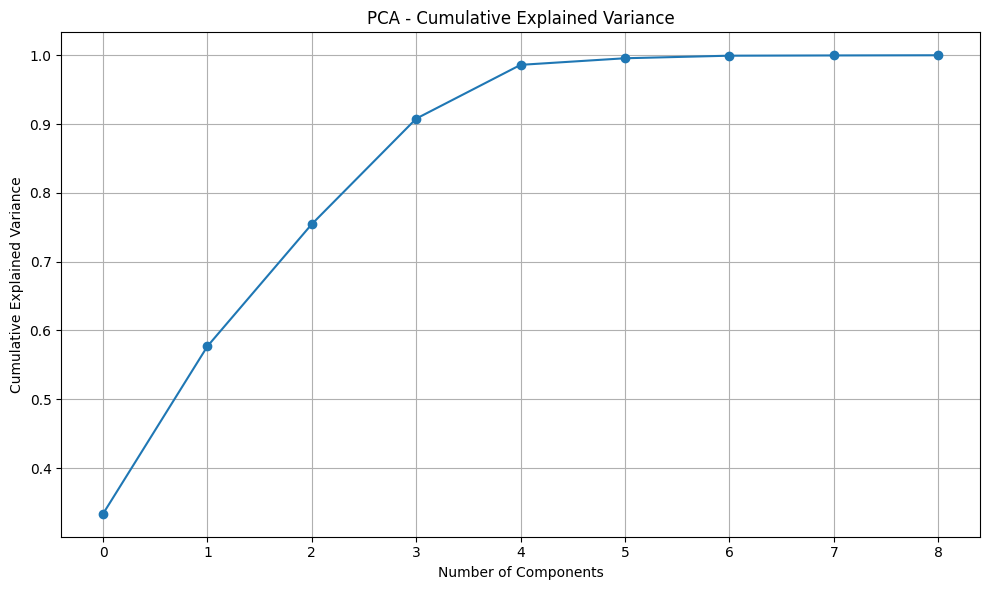

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# Make a DataFrame of PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(df_updated.columns))], index=feature_names)

# Top contributing features to PC1 and PC2
print(loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False))


                               PC1       PC2
flowmeter_6               0.663786 -0.093102
flowmeter_7_imputed       0.615019 -0.211470
flowmeter_2_imputed       0.394149  0.103479
pressure_3                0.116132  0.641072
flowmeter_1_imputed       0.110008  0.691072
flowmeter_5_missing_flag  0.000726 -0.000433
flowmeter_1_missing_flag  0.000693 -0.000883
flowmeter_4_imputed      -0.006662  0.167477
flowmeter_5_imputed      -0.012352 -0.138931


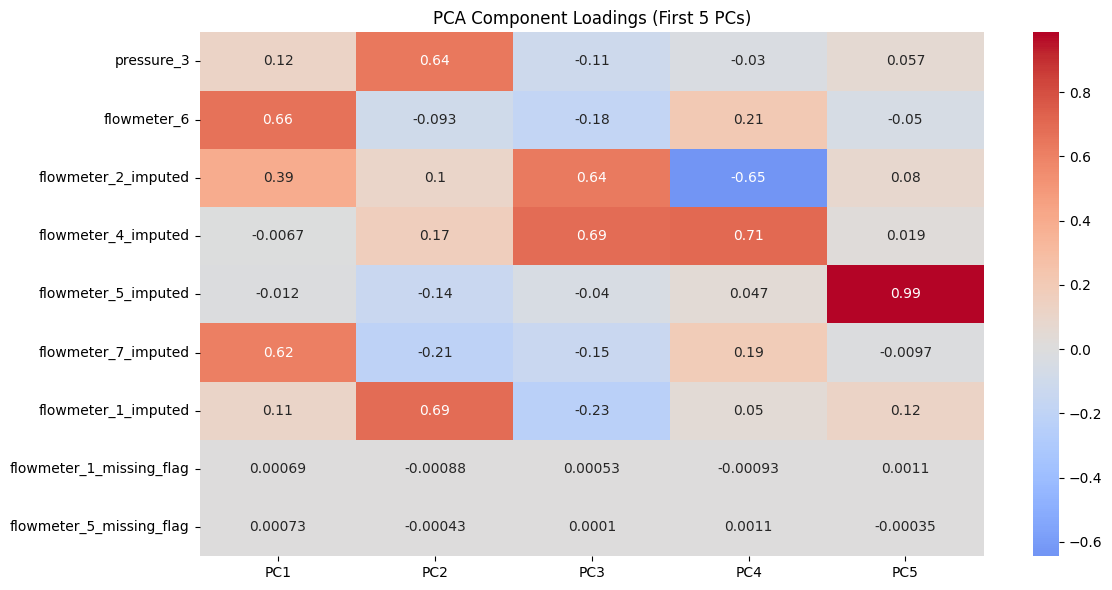

In [31]:
plt.figure(figsize=(12, 6))
sns.heatmap(loadings.iloc[:, :5], cmap='coolwarm', center=0, annot=True)
plt.title("PCA Component Loadings (First 5 PCs)")
plt.tight_layout()
plt.show()


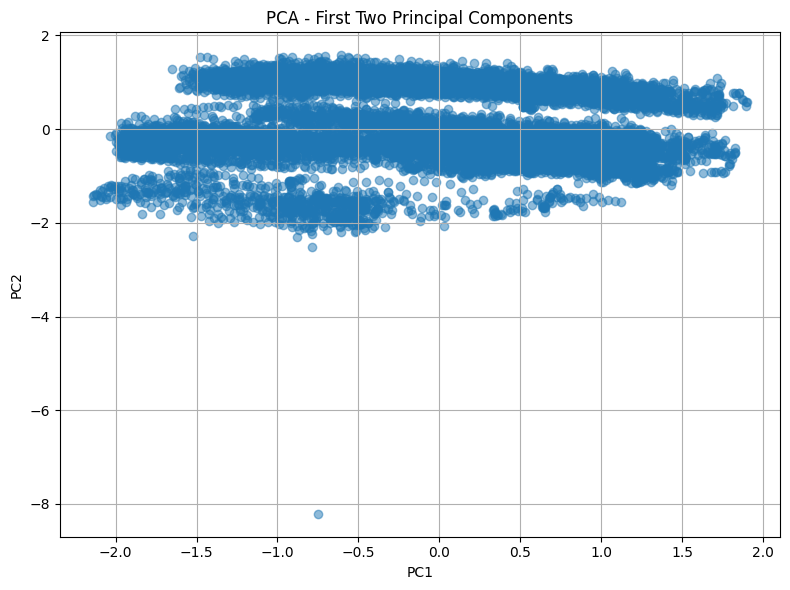

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - First Two Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()


## Why Use Both Rolling Mean and Rolling Standard Deviation

- The **rolling mean** smooths time series data, showing the general trend by averaging values over a moving window.
- The **rolling standard deviation** measures local variability, highlighting how much values fluctuate around the rolling mean.
- Using both together helps detect not only shifts in the average behavior but also changes in data volatility, which is important for spotting anomalies or instability in the series.
- This combined view provides a more complete understanding of the time series dynamics than using either measure alone.


In [33]:
window_size = 24

# List of features
features = [
    'pressure_3',
    'flowmeter_6',
    'flowmeter_5_imputed',
    'flowmeter_1_imputed',
    'flowmeter_2_imputed',
    'flowmeter_4_imputed',
    'flowmeter_7_imputed'
]

# Create rolling mean and std features
for col in features:
    df_updated[f'{col}_roll_mean_4h'] = df_updated[col].rolling(window=window_size, min_periods=24).mean()
    df_updated[f'{col}_roll_std_4h'] = df_updated[col].rolling(window=window_size, min_periods=24).std()

In [34]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   pressure_3                        13248 non-null  float64
 1   flowmeter_6                       13248 non-null  float64
 2   flowmeter_2_imputed               13248 non-null  float64
 3   flowmeter_4_imputed               13248 non-null  float64
 4   flowmeter_5_imputed               13248 non-null  float64
 5   flowmeter_7_imputed               13248 non-null  float64
 6   flowmeter_1_imputed               13248 non-null  float64
 7   flowmeter_1_missing_flag          13248 non-null  int64  
 8   flowmeter_5_missing_flag          13248 non-null  int64  
 9   pressure_3_roll_mean_4h           13225 non-null  float64
 10  pressure_3_roll_std_4h            13225 non-null  float64
 11  flowmeter_6_roll_mean_4h        

In [35]:
for col in df_updated.columns:
    print(col)


pressure_3
flowmeter_6
flowmeter_2_imputed
flowmeter_4_imputed
flowmeter_5_imputed
flowmeter_7_imputed
flowmeter_1_imputed
flowmeter_1_missing_flag
flowmeter_5_missing_flag
pressure_3_roll_mean_4h
pressure_3_roll_std_4h
flowmeter_6_roll_mean_4h
flowmeter_6_roll_std_4h
flowmeter_5_imputed_roll_mean_4h
flowmeter_5_imputed_roll_std_4h
flowmeter_1_imputed_roll_mean_4h
flowmeter_1_imputed_roll_std_4h
flowmeter_2_imputed_roll_mean_4h
flowmeter_2_imputed_roll_std_4h
flowmeter_4_imputed_roll_mean_4h
flowmeter_4_imputed_roll_std_4h
flowmeter_7_imputed_roll_mean_4h
flowmeter_7_imputed_roll_std_4h


In [36]:
print("Features:", features)
print("Roll‐columns missing:",
      [f for f in features
       if f'{f}_roll_mean_4h' not in df_updated.columns
       or f'{f}_roll_std_4h' not in df_updated.columns])


Features: ['pressure_3', 'flowmeter_6', 'flowmeter_5_imputed', 'flowmeter_1_imputed', 'flowmeter_2_imputed', 'flowmeter_4_imputed', 'flowmeter_7_imputed']
Roll‐columns missing: []


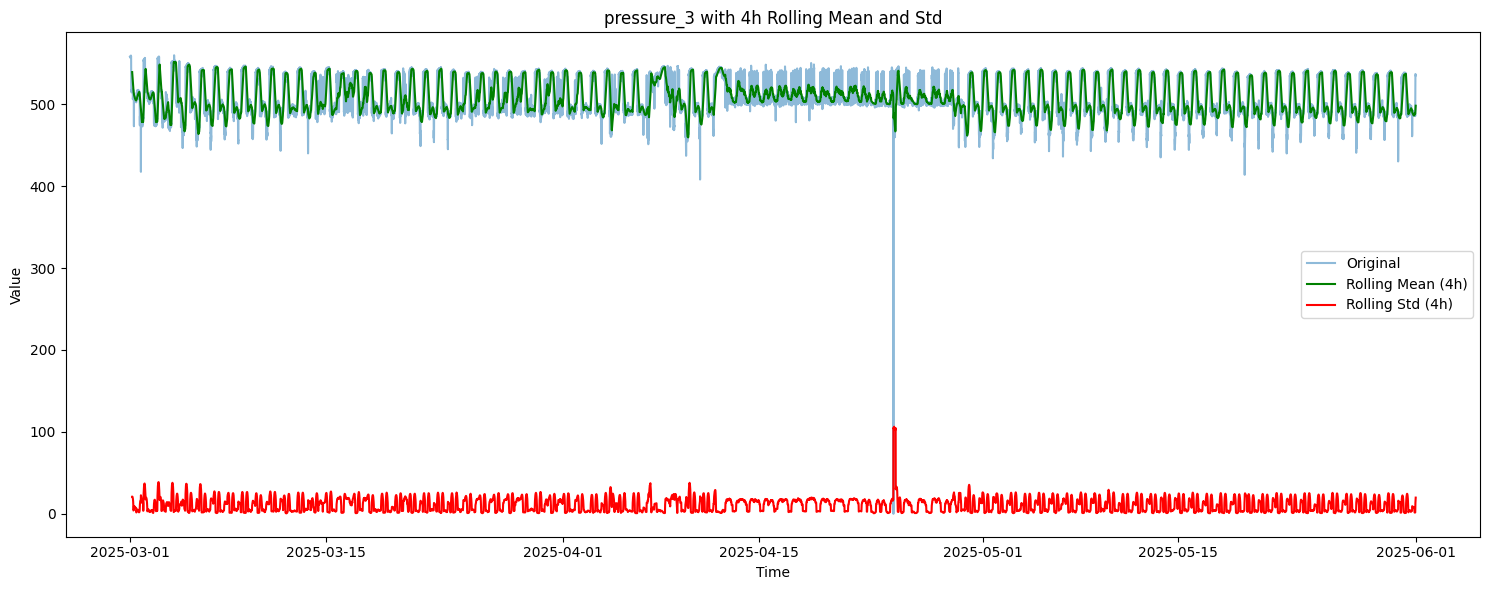

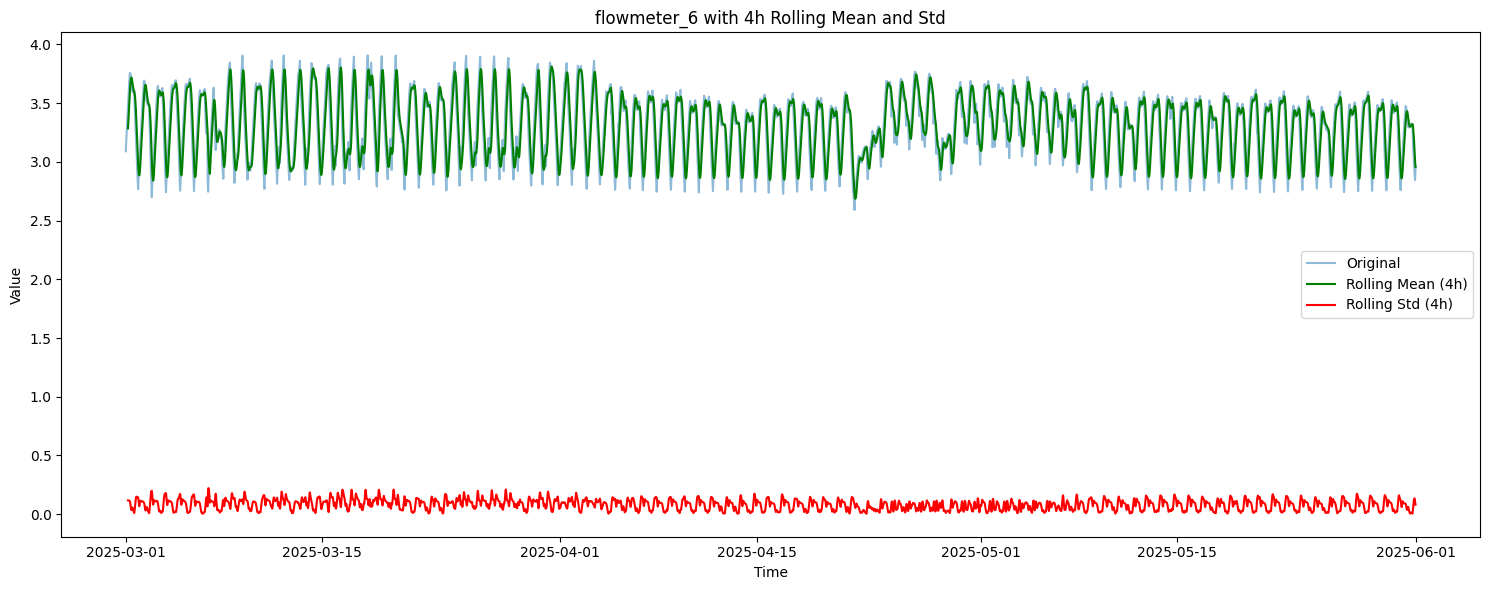

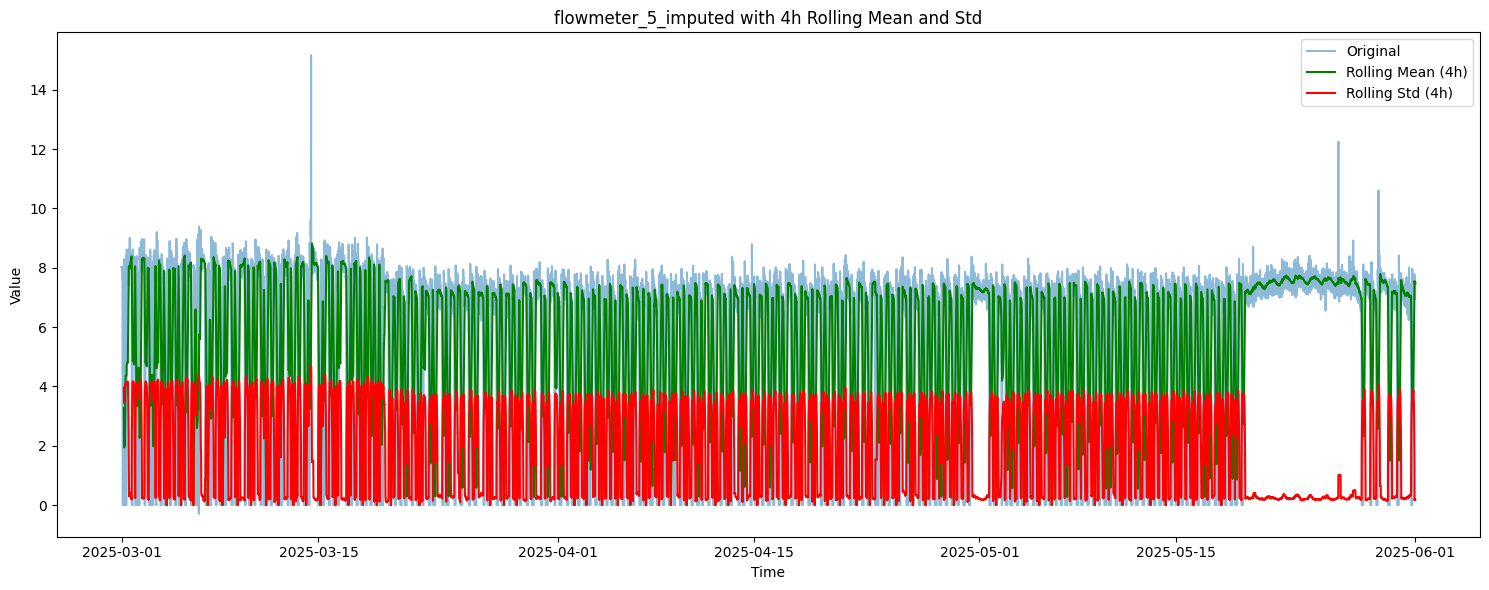

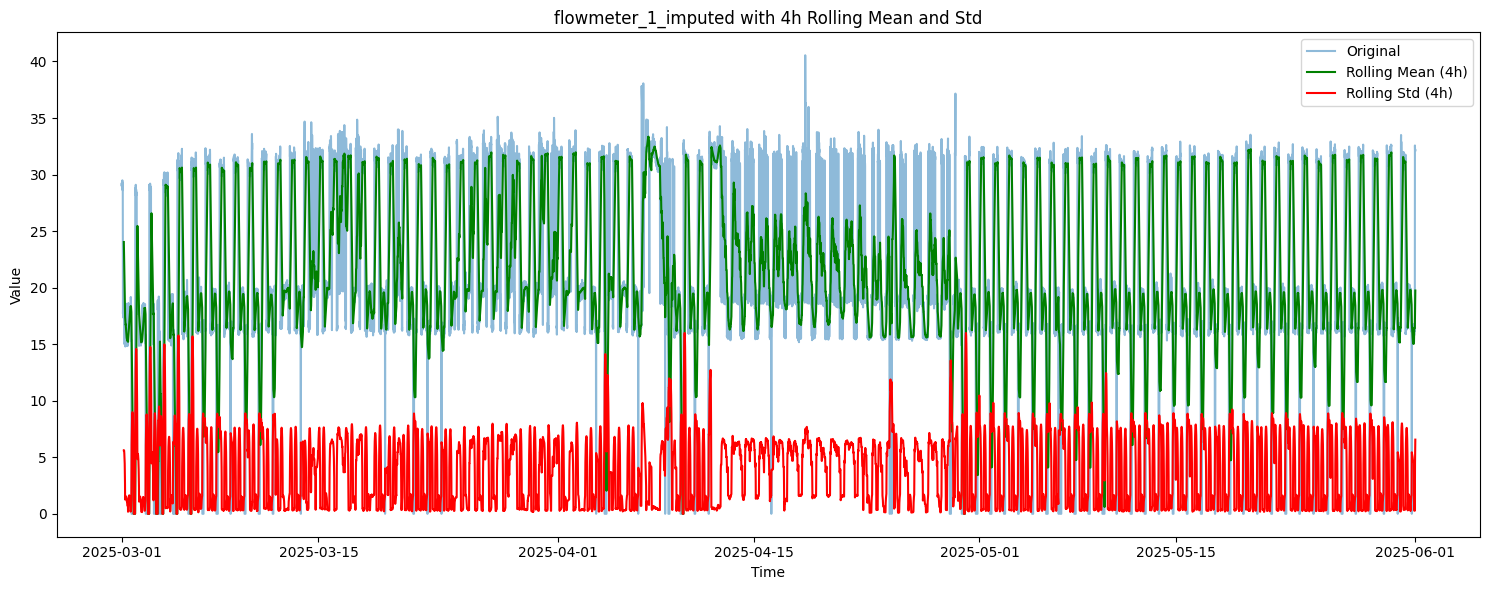

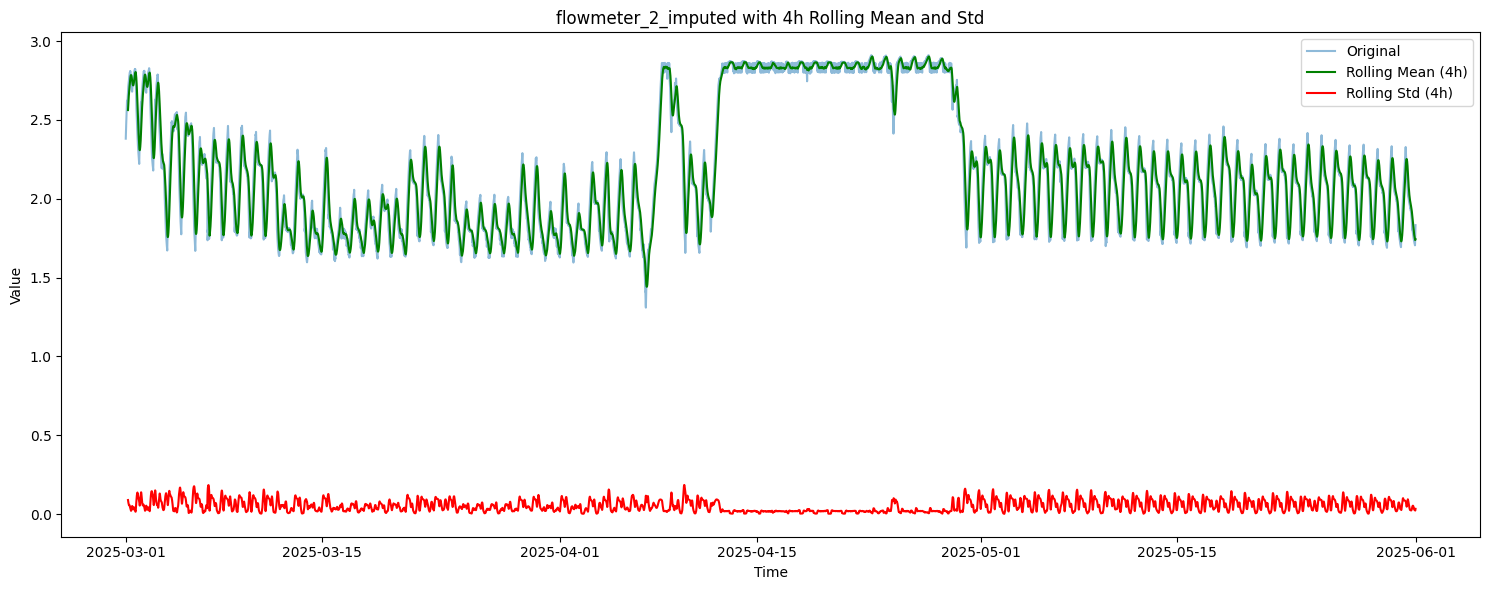

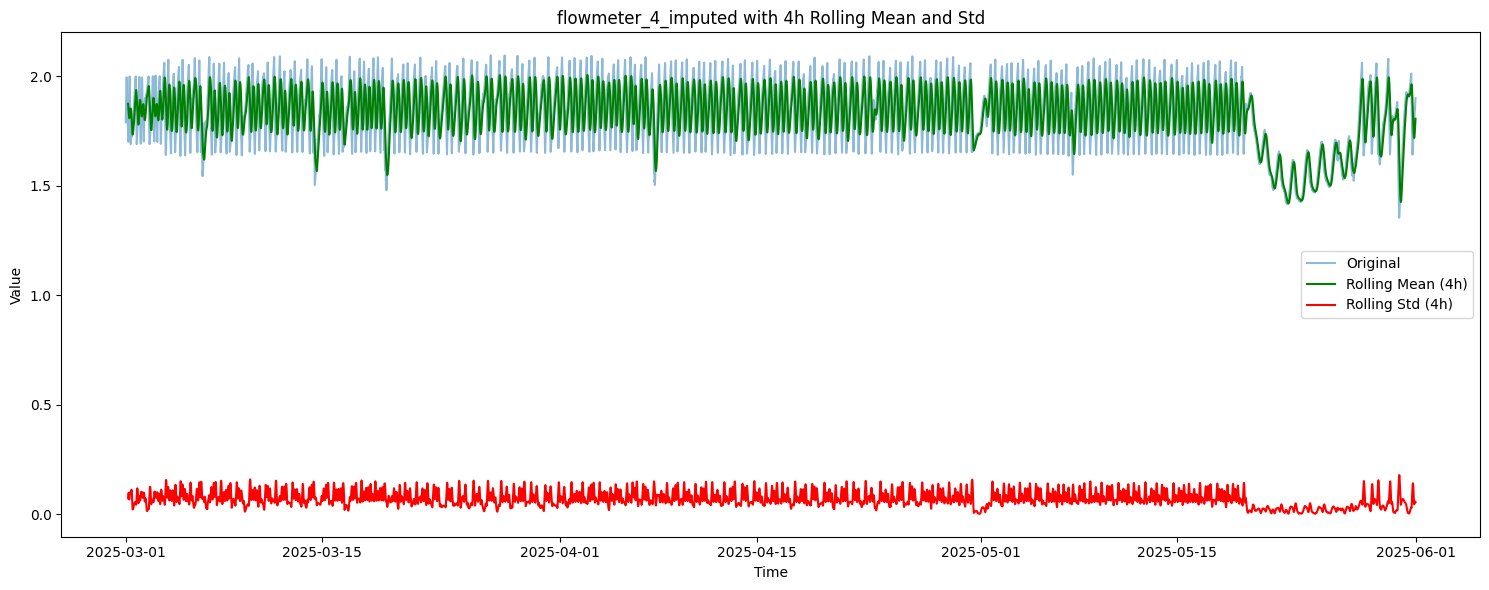

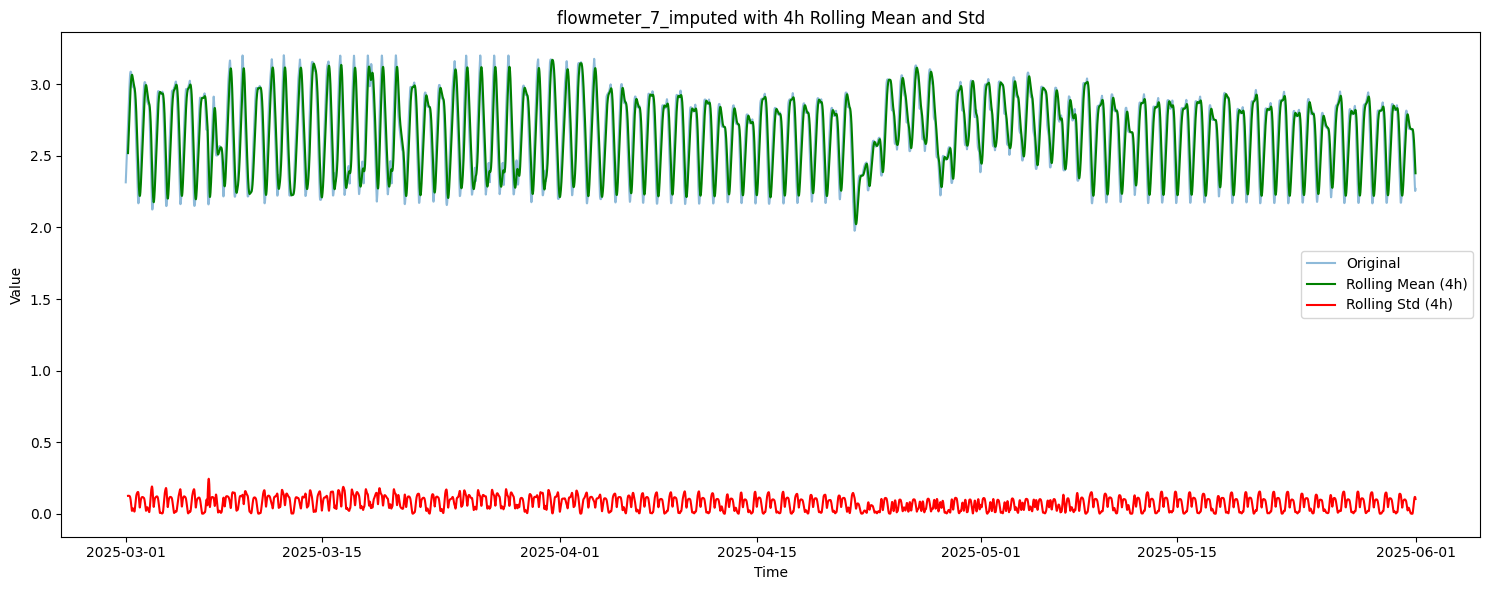

In [37]:

# List of base features you provided
features = [
    'pressure_3',
    'flowmeter_6',
    'flowmeter_5_imputed',
    'flowmeter_1_imputed',
    'flowmeter_2_imputed',
    'flowmeter_4_imputed',
    'flowmeter_7_imputed'
]

# Ensure rolling columns exist and then plot
for feature in features:
    mean_col = f"{feature}_roll_mean_4h"
    std_col  = f"{feature}_roll_std_4h"

    # Optional sanity check
    if mean_col not in df_updated.columns or std_col not in df_updated.columns:
        print(f"Skipping {feature}: missing roll columns")
        continue

    plt.figure(figsize=(15, 6))
    plt.plot(df_updated.index, df_updated[feature], label='Original', alpha=0.5)
    plt.plot(df_updated.index, df_updated[mean_col], label='Rolling Mean (4h)', color='green')
    plt.plot(df_updated.index, df_updated[std_col], label='Rolling Std (4h)', color='red')
    plt.title(f"{feature} with 4h Rolling Mean and Std")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [38]:
window_size = 6

# List of features
features = [
    'pressure_3',
    'flowmeter_6',
    'flowmeter_5_imputed',
    'flowmeter_1_imputed',
    'flowmeter_2_imputed',
    'flowmeter_4_imputed',
    'flowmeter_7_imputed'
]

# Create rolling mean and std features
for col in features:
    df_updated[f'{col}_roll_mean_1h'] = df_updated[col].rolling(window=window_size, min_periods=6).mean()
    df_updated[f'{col}_roll_std_1h'] = df_updated[col].rolling(window=window_size, min_periods=6).std()

In [39]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   pressure_3                        13248 non-null  float64
 1   flowmeter_6                       13248 non-null  float64
 2   flowmeter_2_imputed               13248 non-null  float64
 3   flowmeter_4_imputed               13248 non-null  float64
 4   flowmeter_5_imputed               13248 non-null  float64
 5   flowmeter_7_imputed               13248 non-null  float64
 6   flowmeter_1_imputed               13248 non-null  float64
 7   flowmeter_1_missing_flag          13248 non-null  int64  
 8   flowmeter_5_missing_flag          13248 non-null  int64  
 9   pressure_3_roll_mean_4h           13225 non-null  float64
 10  pressure_3_roll_std_4h            13225 non-null  float64
 11  flowmeter_6_roll_mean_4h        

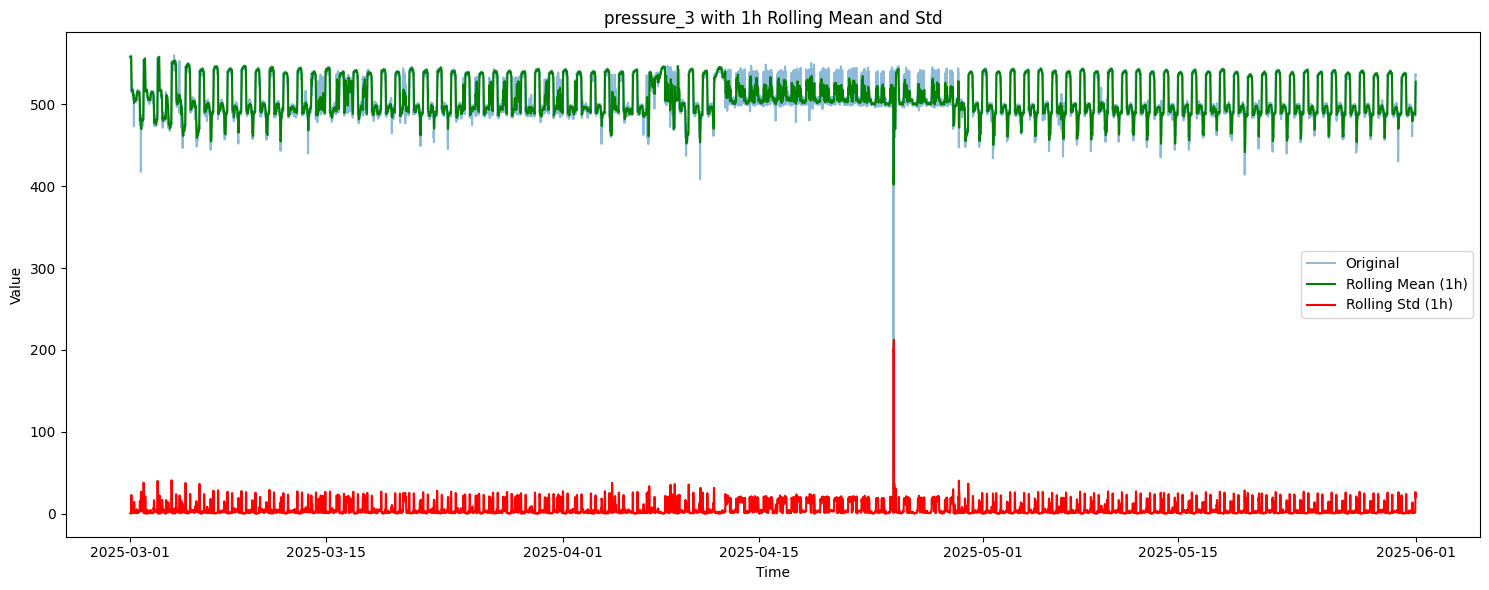

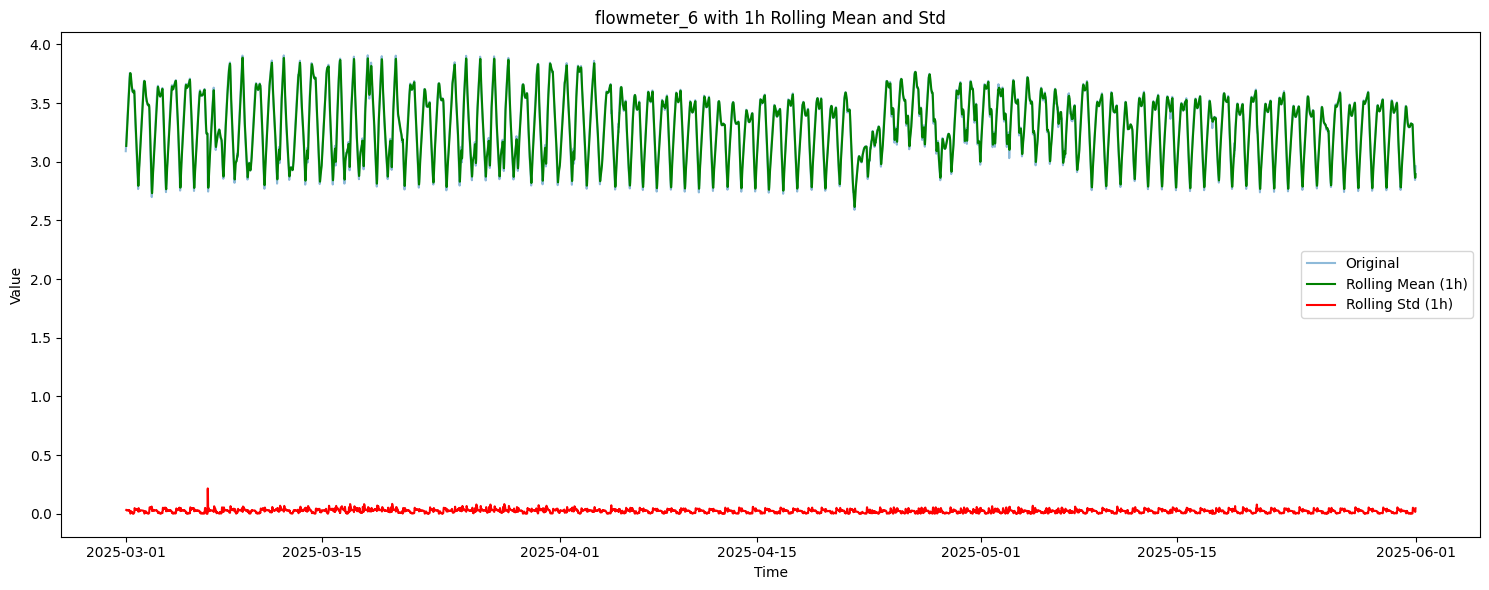

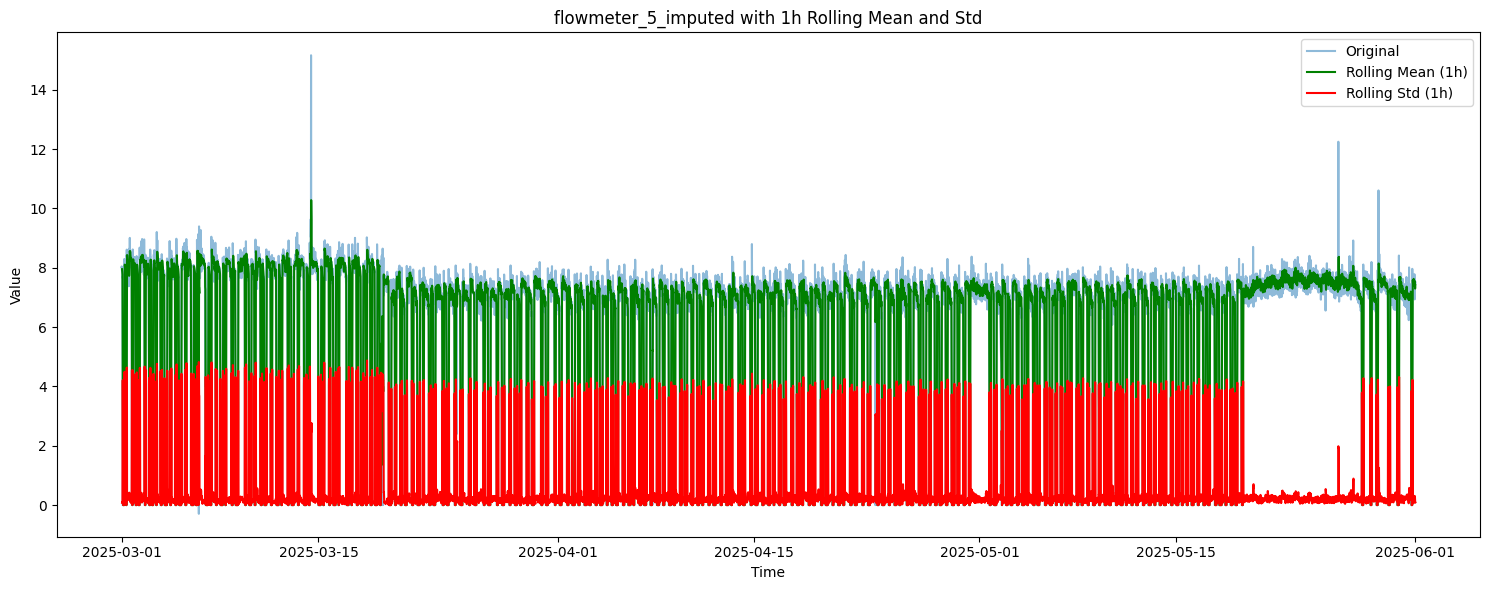

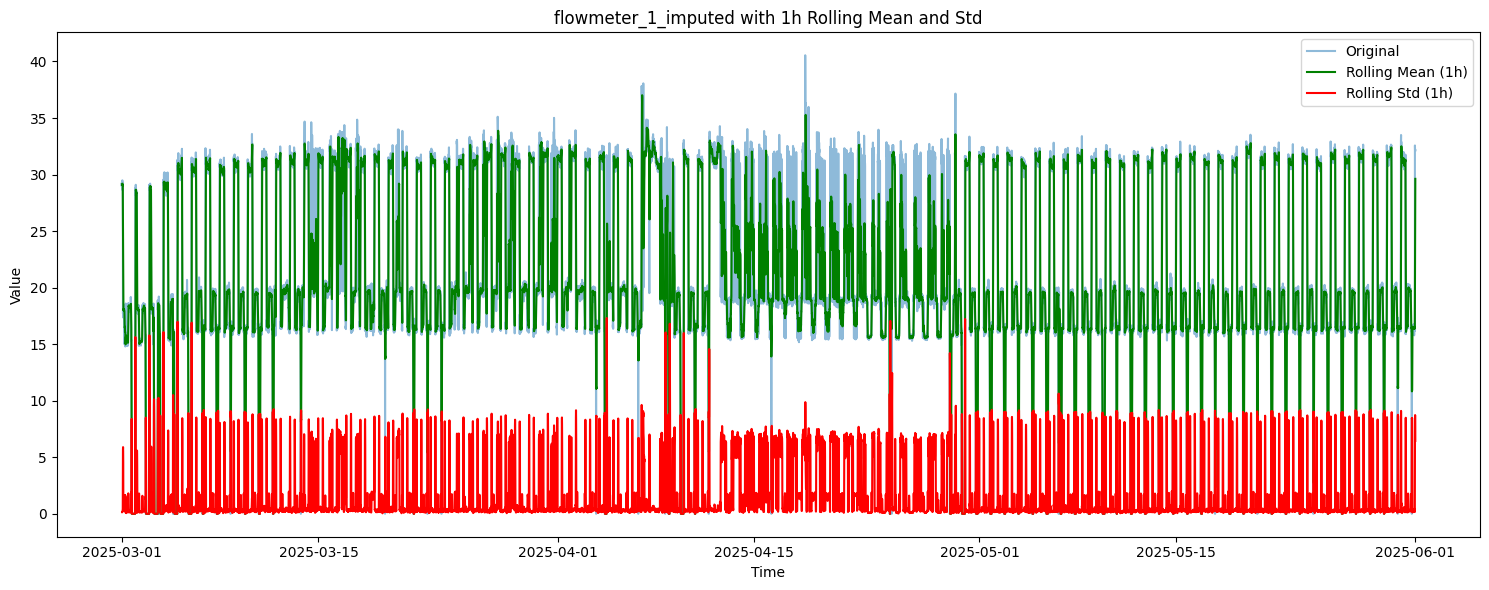

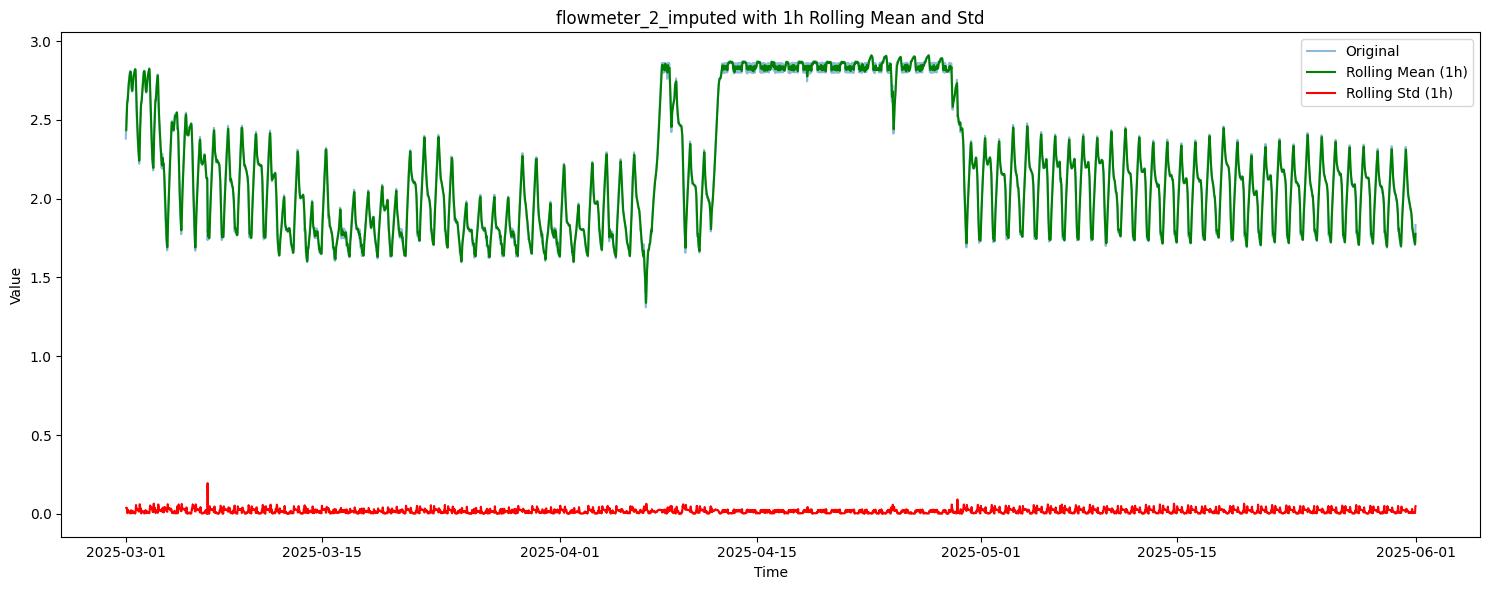

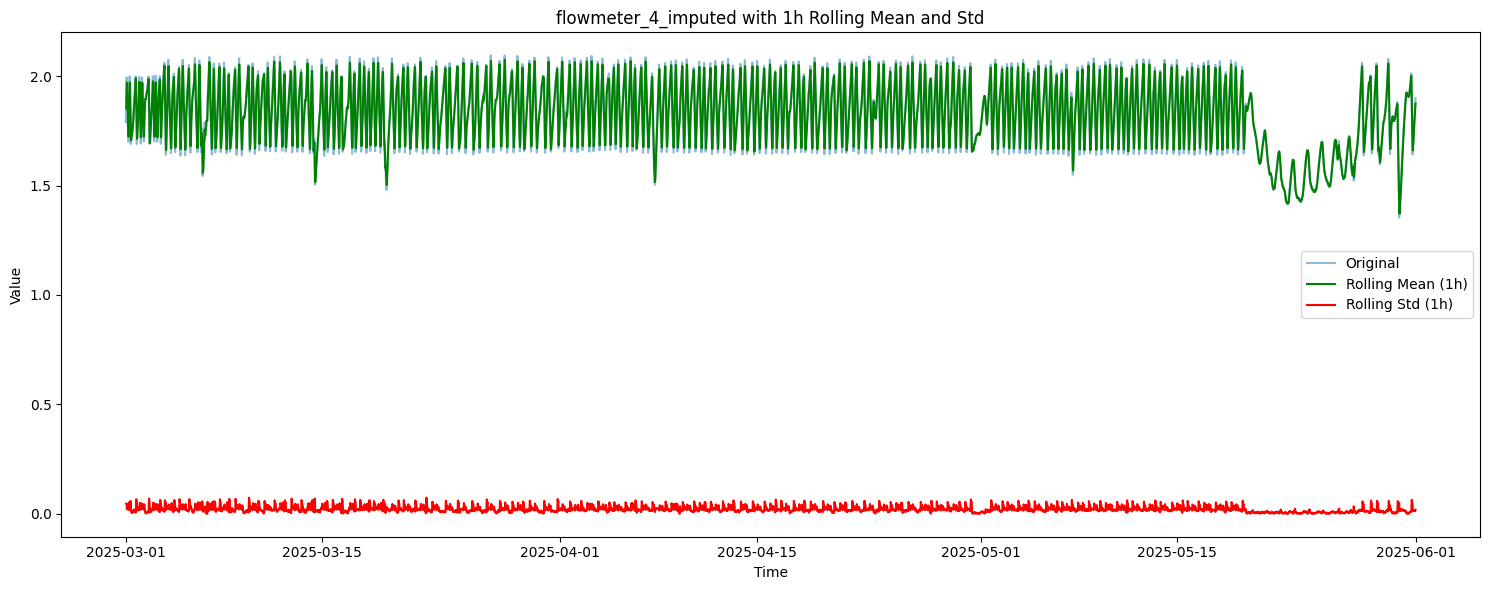

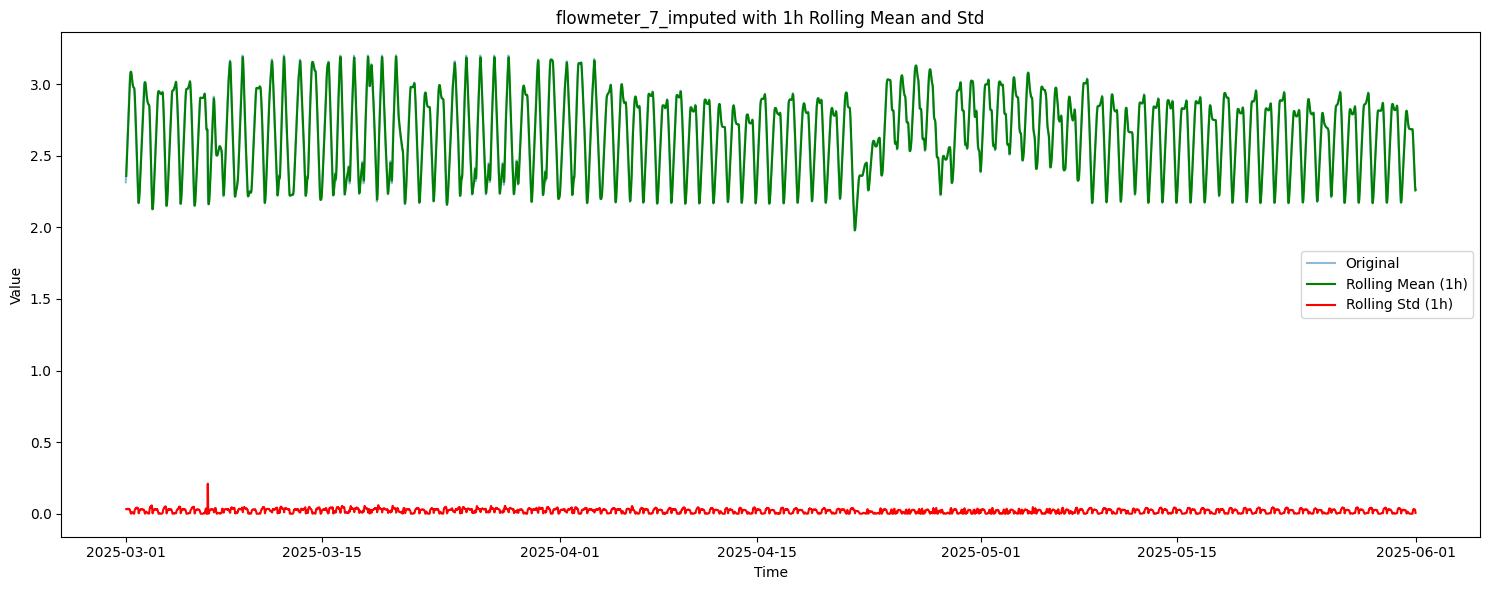

In [40]:

# Ensure rolling columns exist and then plot
for feature in features:
    mean_col = f"{feature}_roll_mean_1h"
    std_col  = f"{feature}_roll_std_1h"

    # Optional sanity check
    if mean_col not in df_updated.columns or std_col not in df_updated.columns:
        print(f"Skipping {feature}: missing roll columns")
        continue

    plt.figure(figsize=(15, 6))
    plt.plot(df_updated.index, df_updated[feature], label='Original', alpha=0.5)
    plt.plot(df_updated.index, df_updated[mean_col], label='Rolling Mean (1h)', color='green')
    plt.plot(df_updated.index, df_updated[std_col], label='Rolling Std (1h)', color='red')
    plt.title(f"{feature} with 1h Rolling Mean and Std")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


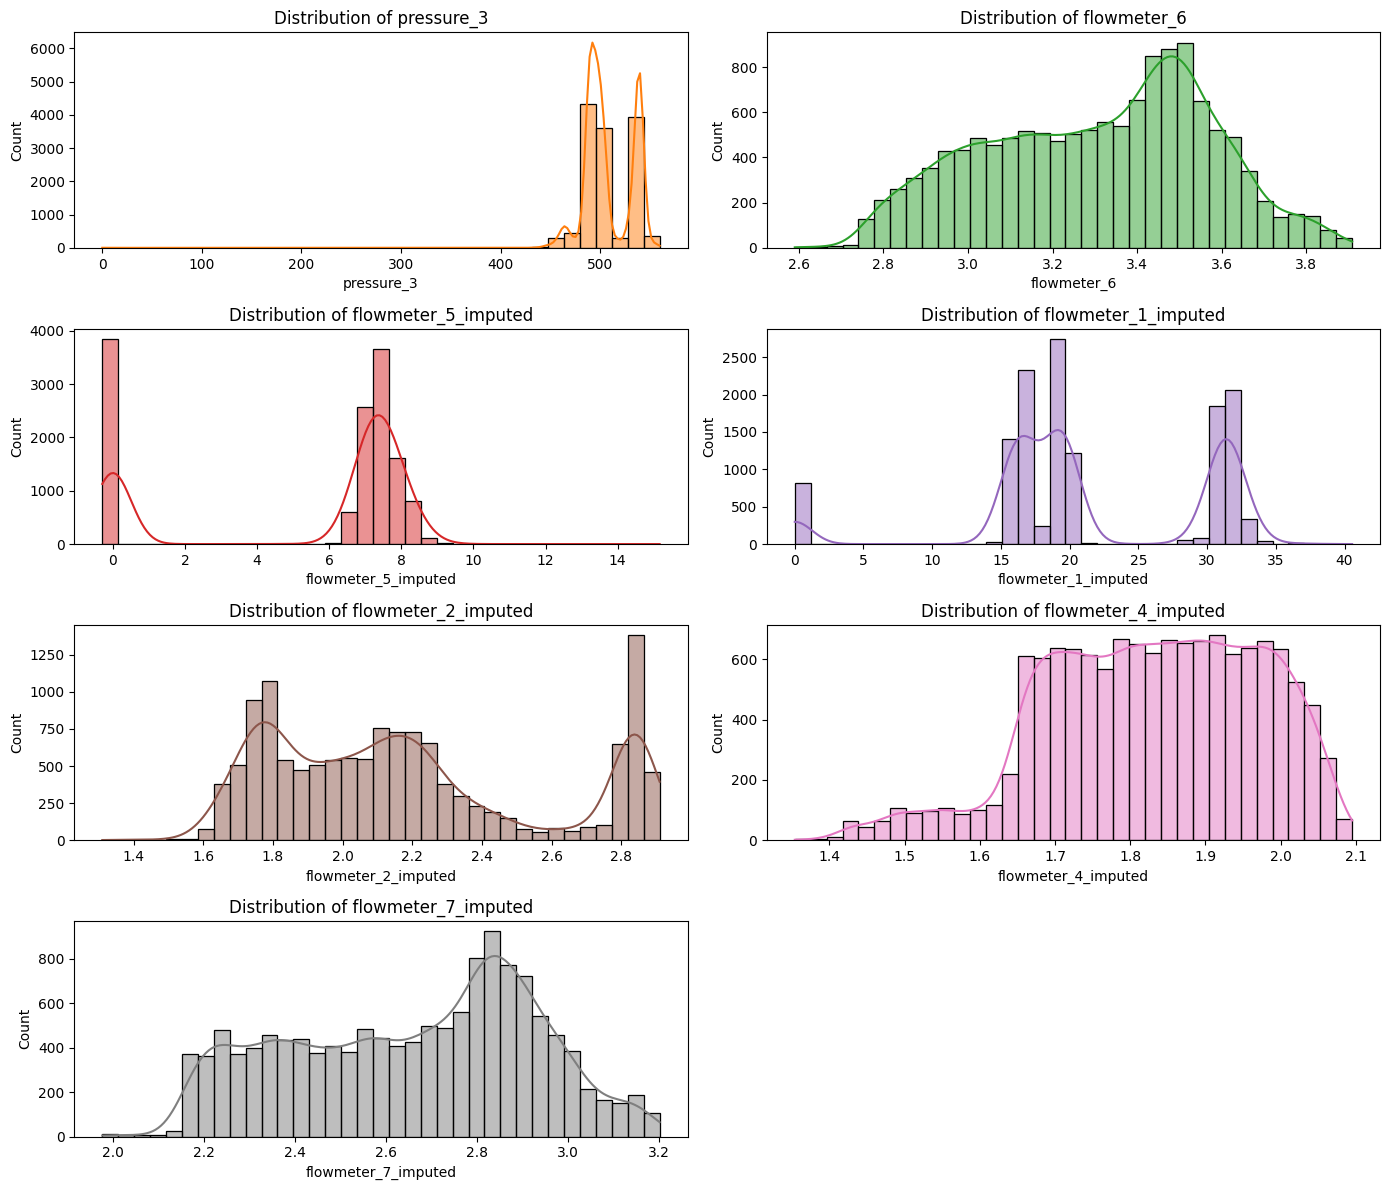

In [41]:

plt.figure(figsize=(14, 12))
for i, col in enumerate(features, start=1):
    plt.subplot(4, 2, i)
    sns.histplot(df_updated[col], kde=True, bins=35, color=f'C{i}')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [49]:
# Function to detect Type A anomalies (sustained deviations ≥ 4 hours)
def detect_type_a_anomalies(df: pd.DataFrame,
                            features: list,
                            roll_mean_cols: list,
                            roll_std_cols: list,
                            pct_threshold: float = 90.0) -> dict:
    """
    Parameters:
      df              : DataFrame containing raw and precomputed 4h rolling stats
      features        : List of raw feature column names (sensor signals)
      roll_mean_cols  : List of matching 4h rolling-mean column names
      roll_std_cols   : List of matching 4h rolling-std column names
      pct_threshold   : Percentile threshold for |z-score| (default=90.0)
    Returns:
      Dict mapping each feature to Boolean Series of Type A flags
    """
    anomaly_flags = {}
    for feat, mean_col, std_col in zip(features, roll_mean_cols, roll_std_cols):
        # retrieve precomputed rolling mean/std for 4h window
        mu = df[mean_col]
        sigma = df[std_col]
        # compute z-score
        z = (df[feat] - mu) / sigma
        # threshold at given percentile on non-null values
        thresh = np.percentile(np.abs(z.dropna()), pct_threshold)
        # flag where |z| exceeds threshold
        anomaly_flags[feat] = (np.abs(z) > thresh)
    return anomaly_flags


In [50]:
# Function to detect Type B anomalies (spikes/dips at a single timestamp)
def detect_type_b_anomalies(df: pd.DataFrame,
                            features: list,
                            roll_mean_cols: list,
                            roll_std_cols: list,
                            pct_threshold: float = 90.0) -> dict:
    """
    Parameters:
      df              : DataFrame containing raw and precomputed 1h rolling stats
      features        : List of raw feature column names
      roll_mean_cols  : List of matching 1h rolling-mean column names
      roll_std_cols   : List of matching 1h rolling-std column names
      pct_threshold   : Percentile threshold for |z-score| (default=90.0)
    Returns:
      Dict mapping each feature to Boolean Series of Type B flags
    """
    anomaly_flags = {}
    for feat, mean_col, std_col in zip(features, roll_mean_cols, roll_std_cols):
        mu = df[mean_col]
        sigma = df[std_col]
        z = (df[feat] - mu) / sigma
        thresh = np.percentile(np.abs(z.dropna()), pct_threshold)
        anomaly_flags[feat] = (np.abs(z) > thresh)
    return anomaly_flags


In [51]:
# Function to enforce minimum duration for Type A anomalies
def validate_duration_constraint(flags: pd.Series,
                                 min_duration: int) -> pd.Series:
    """
    Parameters:
      flags         : Boolean Series of preliminary Type A flags
      min_duration  : Minimum consecutive timestamps to confirm Type A
    Returns:
      Boolean Series where only streaks ≥ min_duration remain True
    """
    validated = pd.Series(False, index=flags.index)
    streak_count = 0
    for idx, is_anomaly in flags.items():
        if is_anomaly:
            streak_count += 1
        else:
            if streak_count >= min_duration:
                # mark the entire streak as True
                validated.iloc[idx - streak_count: idx] = True
            streak_count = 0
    # handle trailing streak
    if streak_count >= min_duration:
        validated.iloc[len(flags) - streak_count:] = True
    return validated


In [52]:
# Function to combine Type A and Type B flags into final classification
def classify_anomalies(type_a_dict: dict,
                       type_b_dict: dict,
                       min_features: int = 3,
                       min_duration: int = 24) -> pd.DataFrame:
    """
    Parameters:
      type_a_dict  : Dict of Boolean Series from detect_type_a_anomalies
      type_b_dict  : Dict of Boolean Series from detect_type_b_anomalies
      min_features : Min number of features that must flag anomaly at a timestamp
      min_duration : Min consecutive timestamps for valid Type A
    Returns:
      DataFrame with columns ['Type_A', 'Type_B'] as Boolean flags
    """
    # aggregate across features per timestamp
    a_sum = pd.DataFrame(type_a_dict).sum(axis=1)
    b_sum = pd.DataFrame(type_b_dict).sum(axis=1)
    # consensus flags
    a_flag = (a_sum >= min_features)
    b_flag = (b_sum >= min_features)
    # enforce duration for Type A
    a_valid = validate_duration_constraint(a_flag, min_duration)
    # Type B only if consensus and not part of Type A
    result = pd.DataFrame({
        'Type_A': a_valid,
        'Type_B': b_flag & (~a_valid)
    })
    return result

In [53]:
# End-to-end function to run the full anomaly detection pipeline
def final_anomaly_classification(df: pd.DataFrame,
                                 features: list,
                                 mean_4h_cols: list,
                                 std_4h_cols: list,
                                 mean_1h_cols: list,
                                 std_1h_cols: list,
                                 pct_threshold: float = 90.0,
                                 min_features: int = None,
                                 min_duration: int = 24) -> pd.DataFrame:
    """
    Parameters:
      df              : DataFrame with raw and rolling-stat columns
      features        : List of raw feature column names
      mean_4h_cols    : List of 4h rolling-mean columns
      std_4h_cols     : List of 4h rolling-std columns
      mean_1h_cols    : List of 1h rolling-mean columns
      std_1h_cols     : List of 1h rolling-std columns
      pct_threshold   : Percentile for z-score thresholding
      min_features    : Min features for consensus (defaults to half+1)
      min_duration    : Min timestamps for Type A validation (e.g., 4)
    Returns:
      DataFrame with Boolean columns 'Type_A' and 'Type_B'
    """
    if min_features is None:
        min_features = len(features) // 2 + 1

    # detect both anomaly types
    type_a = detect_type_a_anomalies(df, features, mean_4h_cols, std_4h_cols, pct_threshold)
    type_b = detect_type_b_anomalies(df, features, mean_1h_cols, std_1h_cols, pct_threshold)
    # classify and return final labels
    return classify_anomalies(type_a, type_b, min_features, min_duration)


In [54]:
# Example usage:
mean_4h_cols = ['pressure_3_roll_mean_4h','flowmeter_6_roll_mean_4h','flowmeter_5_imputed_roll_mean_4h','flowmeter_1_imputed_roll_mean_4h','flowmeter_2_imputed_roll_mean_4h','flowmeter_4_imputed_roll_mean_4h','flowmeter_7_imputed_roll_mean_4h']
std_4h_cols  = ['pressure_3_roll_std_4h', 'flowmeter_6_roll_std_4h','flowmeter_5_imputed_roll_std_4h','flowmeter_1_imputed_roll_std_4h','flowmeter_2_imputed_roll_std_4h','flowmeter_4_imputed_roll_std_4h','flowmeter_7_imputed_roll_std_4h']
mean_1h_cols = ['pressure_3_roll_mean_1h','flowmeter_6_roll_mean_1h','flowmeter_5_imputed_roll_mean_1h','flowmeter_1_imputed_roll_mean_1h','flowmeter_2_imputed_roll_mean_1h','flowmeter_4_imputed_roll_mean_1h','flowmeter_7_imputed_roll_mean_1h']
std_1h_cols  = ['pressure_3_roll_std_1h','flowmeter_6_roll_std_1h','flowmeter_5_imputed_roll_std_1h','flowmeter_1_imputed_roll_std_1h','flowmeter_2_imputed_roll_std_1h','flowmeter_4_imputed_roll_std_1h','flowmeter_7_imputed_roll_std_1h']
labels_df = final_anomaly_classification(df_updated,
                                         features,
                                         mean_4h_cols, std_4h_cols,
                                         mean_1h_cols, std_1h_cols,
                                         pct_threshold=90.0,
                                         min_features=3,
                                         min_duration=24)


In [55]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Type_A  13248 non-null  bool 
 1   Type_B  13248 non-null  bool 
dtypes: bool(2)
memory usage: 129.4 KB


In [60]:
labels_df.sample(10)

,Type_A,Type_B
_id,,
2025-04-18 21:00:00,False,False
2025-04-06 12:00:00,False,False
2025-03-28 08:50:00,False,False
2025-03-12 07:40:00,False,False
2025-04-30 14:50:00,False,False
2025-05-02 23:10:00,False,True
2025-04-26 08:40:00,False,False
2025-04-25 03:40:00,False,False
2025-03-28 14:50:00,False,False


In [61]:
# Count of True and False for 'Type_A'
type_a_counts = labels_df['Type_A'].value_counts()

# Count of True and False for 'Type_B'
type_b_counts = labels_df['Type_B'].value_counts()

print("Type A counts:\n", type_a_counts)
print("\nType B counts:\n", type_b_counts)


Type A counts:
 Type_A
False    13248
Name: count, dtype: int64

Type B counts:
 Type_B
False    12702
True       546
Name: count, dtype: int64
